In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import numpy as np

if torch.cuda.is_available():
    print('Using cuda')
    device = 'cuda'
else:
    print('Using cpu')
    device = 'cpu'

Using cuda


In [2]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

## Data

In [3]:
from data import data_utils

In [4]:
dataset_name = "power-plant"
split=0
standardize = True
validation_ratio = 0.0

In [5]:
uci_data = data_utils.get_uci_data(
    dataset_name,
    splits=split,
    standardize=standardize,
    validation_ratio=validation_ratio,
)
dataset, image_dim, label_dim = uci_data
training_dataset, test_dataset = dataset

In [6]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16384, shuffle=False
)

## Model

In [7]:
from utils import train_utils
import yaml

### Load pretrained CARD model

In [8]:
model_path = os.path.join(
    "models",
    "orig_CARD_pretrain",
    dataset_name,
    f"split_{split}",
    "aux_ckpt.pth",
)
aux_states = torch.load(model_path)

config_path = os.path.join(
    "models",
    "orig_CARD_pretrain",
    dataset_name,
    f"split_{split}",
    "config.yml",
)
with open(os.path.join(config_path), "r") as f:
    card_config = yaml.unsafe_load(f)

regressor = train_utils.setup_CARD_model(
    image_dim=image_dim,
    label_dim=label_dim,
    hidden_layers=card_config.diffusion.nonlinear_guidance.hid_layers,
    use_batchnorm=card_config.diffusion.nonlinear_guidance.use_batchnorm,
    negative_slope=card_config.diffusion.nonlinear_guidance.negative_slope,
    dropout_rate=card_config.diffusion.nonlinear_guidance.dropout_rate,
).to(device)

regressor.load_state_dict(aux_states[0])
regressor.eval()

MLP_CARD(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [9]:
test_performance = train_utils.evaluate_CARD_model(
    model=regressor,
    loader=test_loader,
    device=device,
    standardized=standardize,
)
rmse = np.sqrt(test_performance)
print(
    f"Performance of pre-trained regressor on test set: RMSE={round(rmse, 2)}"
)

Performance of pre-trained regressor on test set: RMSE=4.07


### Load diffusion model

In [10]:
T = 50
distributional_method = "mixednormal"


# Mixed normal
weights_directory = "results_power_CARD_sampling_and_epochs_likeCARD/20250818_095954_power"
#weights_filename = f"Datetime_20250731_122616_Loss_yacht0_MLP_diffusion_{distributional_method}_T{T}_DDIM1"
weights_filename = f"Datetime_20250818_132629_Loss_power-plant0_MLP_diffusion_{distributional_method}_T{T}_DDIM1"
deterministic = False

#Deterministic
# weights_directory = "results_power_CARD_sampling_and_epochs_likeCARD/20250818_095954_power"
# weights_filename = "Datetime_20250731_111314_Loss_yacht0_MLP_diffusion_deterministic_T10_DDIM1"
# deterministic = True
# distributional_method = "deterministic"

filename_to_validate = f'{weights_directory}/{weights_filename}.pt'

In [11]:
training_parameters = {
    'report_every': 50, 
    'seed': 1234, 
    'model': 'MLP', 
    'uncertainty_quantification': 'diffusion', 
    'backbone': 'CARD', 
    'batch_size': 64, 
    'eval_batch_size': 16384, 
    'n_epochs': 5000, 
    'early_stopping': 1000, 
    'init': 'default', 
    'learning_rate': 0.001, 
    'lr_schedule': 'no', 
    'optimizer': 'adam', 
    'gradient_clipping': 1, 
    'data_loader_pin_memory': False, 
    'data_loader_num_workers': 0, 
    'distributed_training': False, 
    'alpha': 0.05, 
    'n_samples_uq': 100, 
    'weight_decay': 0.0, 
    'dropout': 0.1, 
    'hidden_dim': 64, 
    'n_layers': 2, 
    'n_timesteps': T, 
    'distributional_method': distributional_method, #'deterministic', 'mixednormal', #closed_form_mixednormal', 
    'n_components': 3,
    'concat_condition_diffusion': True, 
    'evaluate': True, 
    'x_T_sampling_method': 'CARD', 
    'conditional_free_guidance_training': False, 
    'use_yarin_gal_loss': False, 
    'ddim_sigma': 1.0, 
    'noise_schedule': 'linear', 
    'regressor': 'orig_CARD_pretrain', 
    'metrics_plots': True, 
    'filename_to_validate': filename_to_validate
}

In [12]:
data_parameters = { "dataset_name": dataset_name }

model = train_utils.setup_model(
    data_parameters=data_parameters,
    training_parameters=training_parameters,
    device=device,
    target_dim=image_dim,
    input_dim=label_dim,
)
train_utils.resume(model, filename_to_validate)

In [13]:
model

MLP_diffusion_mixednormal(
  (input_projection): Linear(in_features=1, out_features=128, bias=True)
  (time_projection): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (blocks): Sequential2Inputs(
    (0): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (4): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)


## Apply model on test set

In [14]:
import evaluate
from utils import losses

In [15]:
alpha = 0.05

In [16]:
closed_form = True


with torch.no_grad():
    for target, input in test_loader:
        input = input.to(device)
        target = target.to(device)
        batch_size = input.shape[0]

        res = evaluate.generate_samples(
            uncertainty_quantification="diffusion",
            model=model,
            n_timesteps=training_parameters["n_timesteps"],
            x=input,
            target=target,
            n_samples=training_parameters["n_samples_uq"],
            x_T_sampling_method=training_parameters["x_T_sampling_method"],
            distributional_method=training_parameters["distributional_method"],
            closed_form= closed_form,
            regressor=regressor,
            cfg_scale=0,
            ddim_churn=1.0,
            noise_schedule=training_parameters["noise_schedule"],
            metrics_plots=False,
        )

predicted_images = res.cpu()

In [17]:
predicted_images.shape

torch.Size([957, 1, 1, 100])

In [18]:
predicted_images = predicted_images.cpu() # out.squeeze().cpu()
predicted_images.shape

torch.Size([957, 1, 1, 100])

In [19]:
if standardize:
    target = test_loader.dataset.destandardize_output(target)
    predicted_images = test_loader.dataset.destandardize_output(predicted_images)

In [20]:
coverage_loss = losses.Coverage(alpha)

In [21]:
coverage = coverage_loss(predicted_images, target.cpu(), ensemble_dim=-1).item()
print(f"Coverage {coverage}")

Coverage 0.9885057210922241


In [22]:
predicted_images.squeeze().mean(dim=-1)

tensor([444.3264, 464.5176, 437.4380, 463.6773, 464.8015, 472.1382, 448.8004,
        430.5345, 469.4038, 454.4359, 441.7646, 448.1052, 437.4285, 446.7387,
        437.2242, 480.4153, 468.3224, 446.8176, 456.7827, 436.8016, 477.5830,
        438.3892, 469.5337, 465.9323, 437.4339, 435.7177, 451.1037, 459.8932,
        438.2393, 445.8212, 456.8598, 439.6366, 476.5167, 473.4464, 438.8154,
        434.5596, 445.7828, 470.3012, 448.3717, 431.0529, 434.4798, 461.8148,
        471.3419, 455.1776, 464.7906, 473.0504, 443.8912, 431.4781, 451.6600,
        484.8925, 462.8249, 456.4286, 480.4189, 434.8726, 463.2043, 436.9052,
        476.2267, 445.3677, 448.4263, 469.5973, 455.9431, 433.4407, 448.5421,
        476.1874, 468.1248, 458.1204, 445.0717, 464.4925, 445.0201, 452.0148,
        471.1572, 470.9259, 491.7249, 436.5644, 432.8632, 439.7115, 438.2046,
        463.6577, 473.5045, 472.7323, 443.5845, 431.3799, 435.4866, 432.1666,
        432.1591, 434.7602, 438.9782, 468.0573, 444.4117, 488.45

tensor([ 7.5189,  0.8424,  3.0563,  2.0948, 42.6141, 55.4406,  0.2675,  4.7077,
         3.7940,  0.2198,  0.7335,  0.6414,  1.4918, 32.7057,  5.4518,  0.5153,
         0.1482,  0.6136, 13.8206, 12.8938,  0.1724, 48.2403,  0.2457,  0.8571,
         1.2265,  4.1636,  3.1202,  0.9617,  0.4429, 23.3593,  8.1823])

In [23]:
mse = ((predicted_images.squeeze().mean(dim=-1) - target.squeeze().cpu())**2).mean()
print(f"RMSE {np.sqrt(mse)}")

RMSE 3.652003526687622


Only last timestep sampling: RMSE 0.7630231380462646 & Coverage 0.64

In [24]:
regressor_pred = test_loader.dataset.destandardize_output(regressor(input).squeeze().cpu().detach())
                                         
mse = ((regressor_pred - target.squeeze().cpu())**2).mean()
print(f"RMSE (regressor) {np.sqrt(mse)}")

RMSE (regressor) 4.071506500244141


In [25]:
regressor(test_dataset[:][1].to(device)).squeeze().cpu().detach()[:5]

tensor([-0.5745,  0.6451, -1.0163,  0.5176,  0.7128])

In [26]:
res.squeeze().mean(dim=-1)[:5]

tensor([-0.5921,  0.5944, -0.9969,  0.5450,  0.6111], device='cuda:0')

### Plot

In [27]:
import matplotlib.pyplot as plt

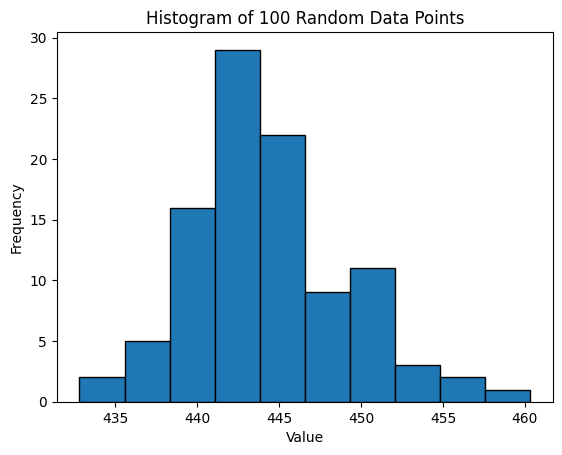

In [28]:
plt.hist(predicted_images.squeeze()[0], bins=10, edgecolor='black')
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 100 Random Data Points')

# Show the plot
plt.show()

## Inspect model on test data

In [29]:
import matplotlib.pyplot as plt

In [30]:
model.eval()

MLP_diffusion_mixednormal(
  (input_projection): Linear(in_features=1, out_features=128, bias=True)
  (time_projection): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (blocks): Sequential2Inputs(
    (0): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (3): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (4): MLPBlock(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)


In [31]:
TEST_SAMPLE_IDX = 4

target, conditioning = test_dataset[TEST_SAMPLE_IDX]
target, conditioning = target.to(device), conditioning.to(device) 
pred = regressor(conditioning).detach()

In [32]:
conditioning

tensor([[-0.6786, -0.7734,  1.3703, -0.4983]], device='cuda:0')

In [33]:
target

tensor([[0.4747]], device='cuda:0')

In [34]:
# x = torch.randn((1,1,1)).to(device)
# print(f"x = {x}; pred = {pred}")
# x += pred

N_SAMPLES = 5
TIMESTEPS = T

i = 49
t = torch.tensor([i]).long().to(device)

ddim_sigma = 0.0

In [35]:
x_repeated = torch.randn((N_SAMPLES,1,1)).to(device) # x.repeat_interleave(N_SAMPLES, dim=0)
cond_repeated = conditioning.unsqueeze(1).repeat_interleave(N_SAMPLES, dim=0)
pred_repeated = pred.unsqueeze(1).repeat_interleave(N_SAMPLES, dim=0)

x_repeated += pred_repeated

print(f"x[0]={round(x_repeated.squeeze()[0].item(), 3)}, pred={round(pred_repeated.squeeze()[0].item(), 3)}, target={round(target.item(), 3)}")
print(f"mean(x)={x_repeated.mean().item()}, std(x)={x_repeated.std().item()}")

x[0]=0.783, pred=0.713, target=0.475
mean(x)=0.7212560772895813, std(x)=0.3546837568283081


In [36]:
beta_start = 1e-4
beta_end = 0.02
BETA = torch.linspace(beta_start, beta_end, TIMESTEPS).to(device)

ALPHA = 1.0 - BETA
ALPHA_HAT = torch.cumprod(ALPHA, dim=0)        

In [37]:
mse_sum = 0
for curr_target, curr_input in test_dataset:
    pred_unnormalized = test_dataset.destandardize_output(regressor(curr_input.to(device)))
    curr_target_unnormalized = test_dataset.destandardize_output(curr_target.to(device))
    
    mse_sum += (pred_unnormalized - curr_target_unnormalized)**2

mse_avg = mse_sum / len(test_dataset)

print(f"Pretrained regressor rmse on test set: {round(torch.sqrt(mse_avg.detach()).item(), 3)}")

Pretrained regressor rmse on test set: 4.072


In [38]:
target

tensor([[0.4747]], device='cuda:0')

### Closed-form mixednormal

In [39]:
def sample_x_t_closed_form(
    x, t, predicted_noise_distribution_params, pred, i, method, final_timestep_variance_scaling=1.0,
):
    if method == "closed_form_normal":
        predicted_noise_mu = predicted_noise_distribution_params[..., 0]
        predicted_noise_sigma = predicted_noise_distribution_params[..., 1]
    elif method == "closed_form_mixednormal":
        mu = predicted_noise_distribution_params[..., 0]
        sigma = predicted_noise_distribution_params[..., 1]
        weights = predicted_noise_distribution_params[..., 2]
        sampled_weights = torch.distributions.Categorical(weights).sample()
        predicted_noise_mu = torch.gather(mu, dim=-1, index=sampled_weights.unsqueeze(-1)).squeeze(-1)
        predicted_noise_sigma = torch.gather(
            sigma, dim=-1, index=sampled_weights.unsqueeze(-1)
        ).squeeze(-1)
    else:
        raise Exception(f"Invalid method {method}")
    
    alpha = ALPHA[t]
    alpha_hat = ALPHA_HAT[t]
    beta = BETA[t]
    # Reshape
    alpha = alpha.view(*alpha.shape, *(1,) * (x.ndim - alpha.ndim)).expand(x.shape)
    alpha_hat = alpha_hat.view(
        *alpha_hat.shape, *(1,) * (x.ndim - alpha_hat.ndim)
    ).expand(x.shape)
    beta = beta.view(*beta.shape, *(1,) * (x.ndim - beta.ndim)).expand(x.shape)
    if i > 1:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)

    variance_factor_default = beta**2 / (alpha * (1 - alpha_hat))

    y_hat_0 = (
        1
        / torch.sqrt(alpha_hat)
        * (
            x
            - (1 - torch.sqrt(alpha_hat)) * pred
            - torch.sqrt(1 - alpha_hat) * predicted_noise_mu
        )
    )
    if i > 1:
        alpha_hat_t_minus_1 = ALPHA_HAT[t - 1]
        alpha_hat_t_minus_1 = alpha_hat_t_minus_1.view(
            *alpha_hat_t_minus_1.shape,
            *(1,) * (x.ndim - alpha_hat_t_minus_1.ndim),
        ).expand(x.shape)

        gamma_0 = beta * torch.sqrt(alpha_hat_t_minus_1) / (1 - alpha_hat)
        gamma_1 = (
            (1 - alpha_hat_t_minus_1) * torch.sqrt(alpha) / (1 - alpha_hat)
        )
        gamma_2 = 1 + (torch.sqrt(alpha_hat) - 1) * (
            torch.sqrt(alpha) + torch.sqrt(alpha_hat_t_minus_1)
        ) / (1 - alpha_hat)

        beta_wiggle = (1 - alpha_hat_t_minus_1) / (1 - alpha_hat) * beta

        variance_factor_CARD = alpha_hat_t_minus_1 * variance_factor_default
        if i == 1:
            variance_factor_CARD *= final_timestep_variance_scaling

        x = (gamma_0 * y_hat_0 + gamma_1 * x + gamma_2 * pred) + ddim_sigma * torch.sqrt(
            variance_factor_CARD * (predicted_noise_sigma)**2 + beta_wiggle
        ) * noise
    else:
        x = y_hat_0
        
    return x

In [40]:
if not deterministic:
    with torch.no_grad():
        x_closedform = x_repeated.clone()

        distr_per_t_closed_form = [
            (x_closedform.mean().cpu(), x_closedform.std().cpu())
        ]
        x_trajectories_closedform = [
            x_closedform
        ]

        for i in reversed(range(1, TIMESTEPS)):
            t = torch.tensor([i]).long().to(device)
            curr_t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)
            #curr_t_repeated = t_repeated
            
            predicted_noise_distribution_params = model(
                x_closedform, curr_t_repeated, cond_repeated, pred_repeated,
            )

            x_closedform = sample_x_t_closed_form(
                x_closedform,
                curr_t_repeated,
                predicted_noise_distribution_params,
                pred_repeated,
                i,
                "closed_form_mixednormal",
            )

            distr_per_t_closed_form.append(
                (x_closedform.mean(axis=0).cpu(), x_closedform.std(axis=0).cpu())
            )
            x_trajectories_closedform.append(
                x_closedform
            )

### Sample mixednormal

In [41]:
def sample_noise(model, x, t, conditioning, pred):
    predicted_mixture = model(x, t, conditioning, pred)
    mu = predicted_mixture[..., 0]
    sigma = predicted_mixture[..., 1]
    weights = predicted_mixture[..., 2]
    sampled_weights = torch.distributions.Categorical(weights).sample()
    sampled_mu = torch.gather(mu, dim=-1, index=sampled_weights.unsqueeze(-1))
    sampled_sigma = torch.gather(
        sigma, dim=-1, index=sampled_weights.unsqueeze(-1)
    )
    predicted_noise = sampled_mu + sampled_sigma * torch.randn_like(
        sampled_mu, device=device
    )
    predicted_noise = predicted_noise.squeeze(-1)

    #print(f"sampled_mu={sampled_mu.squeeze()}; sampled_sigma={sampled_sigma.squeeze()}")

    return predicted_noise

In [42]:
def sample_x_t_inference(x, t, predicted_noise, pred, i):
    alpha = ALPHA[t]
    alpha_hat = ALPHA_HAT[t]
    beta = BETA[t]
    # Reshape
    alpha = alpha.view(*alpha.shape, *(1,) * (x.ndim - alpha.ndim)).expand(x.shape)
    alpha_hat = alpha_hat.view(
        *alpha_hat.shape, *(1,) * (x.ndim - alpha_hat.ndim)
    ).expand(x.shape)
    beta = beta.view(*beta.shape, *(1,) * (x.ndim - beta.ndim)).expand(x.shape)
    if i > 1:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)

    y_hat_0 = (
        1
        / torch.sqrt(alpha_hat)
        * (
            x
            - (1 - torch.sqrt(alpha_hat)) * pred
            - torch.sqrt(1 - alpha_hat) * predicted_noise
        )
    )
    if i > 1:
        alpha_hat_t_minus_1 = ALPHA_HAT[t - 1]
        alpha_hat_t_minus_1 = alpha_hat_t_minus_1.view(
            *alpha_hat_t_minus_1.shape,
            *(1,) * (x.ndim - alpha_hat_t_minus_1.ndim),
        ).expand(x.shape)

        gamma_0 = beta * torch.sqrt(alpha_hat_t_minus_1) / (1 - alpha_hat)
        gamma_1 = (
            (1 - alpha_hat_t_minus_1) * torch.sqrt(alpha) / (1 - alpha_hat)
        )
        gamma_2 = 1 + (torch.sqrt(alpha_hat) - 1) * (
            torch.sqrt(alpha) + torch.sqrt(alpha_hat_t_minus_1)
        ) / (1 - alpha_hat)

        beta_wiggle = (1 - alpha_hat_t_minus_1) / (1 - alpha_hat) * beta

        x = (
            gamma_0 * y_hat_0
            + gamma_1 * x
            + gamma_2 * pred
            + ddim_sigma * torch.sqrt(beta_wiggle) * noise
        )

    else:
        x = y_hat_0

    return x

In [43]:
if not deterministic:
    with torch.no_grad():
        x_sampledform = x_repeated.clone()

        distr_per_t_sampled_form = [
            (x_sampledform.mean().cpu(), x_sampledform.std().cpu())
        ]
        x_trajectories_sampledform = [
            x_sampledform
        ]

        for i in reversed(range(1, TIMESTEPS)):
            t = torch.tensor([i]).long().to(device)
            curr_t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)

            predicted_noise = sample_noise(model, x_sampledform, curr_t_repeated, cond_repeated, pred_repeated)
            x_sampledform = sample_x_t_inference(x_sampledform, curr_t_repeated, predicted_noise, pred_repeated, i)

            distr_per_t_sampled_form.append(
                (x_sampledform.mean(axis=0).cpu(), x_sampledform.std(axis=0).cpu())
            )
            x_trajectories_sampledform.append(
                x_sampledform
            )


### Deterministic

In [44]:
if deterministic:
    with torch.no_grad():
        x_deterministic = x_repeated.clone()

        distr_per_t_deterministic = [
            (x_deterministic.mean().cpu(), x_deterministic.std().cpu())
        ]
        x_trajectories_deterministic = [
            x_deterministic
        ]

        for i in reversed(range(1, TIMESTEPS)):
            # t = torch.tensor([i]).long().to(device)
            # t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)
            t_repeated = (torch.ones(N_SAMPLES) * i).long().to(device)
            predicted_noise = model(x_deterministic, t_repeated, cond_repeated, pred_repeated)
            x_deterministic = sample_x_t_inference(x_deterministic, t_repeated, predicted_noise, pred_repeated, i)

            distr_per_t_deterministic.append(
                (x_deterministic.mean(axis=0).cpu(), x_deterministic.std(axis=0).cpu())
            )

            x_trajectories_deterministic.append(
                x_deterministic
            )

In [45]:
distr_per_t_sampled_form[-1][0]

tensor([[0.5652]])

### Plots

#### Closed-form

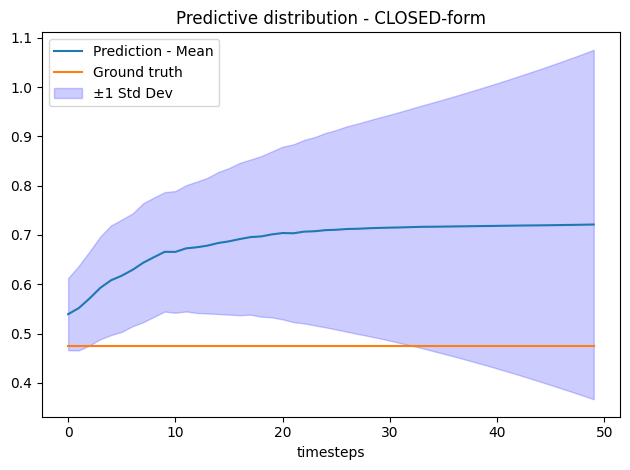

In [46]:
if not deterministic:
    means_over_time_closed_form = np.array([distr_per_t_closed_form[t][0].squeeze() for t in range(TIMESTEPS)]).squeeze()
    stds_over_time_closed_form =  np.array([distr_per_t_closed_form[t][1].squeeze() for t in range(TIMESTEPS)]).squeeze()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    plt.plot(reversed_timesteps, means_over_time_closed_form, label="Prediction - Mean")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.fill_between(np.array(reversed_timesteps), means_over_time_closed_form - stds_over_time_closed_form, means_over_time_closed_form + stds_over_time_closed_form, color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - CLOSED-form")
    plt.tight_layout()


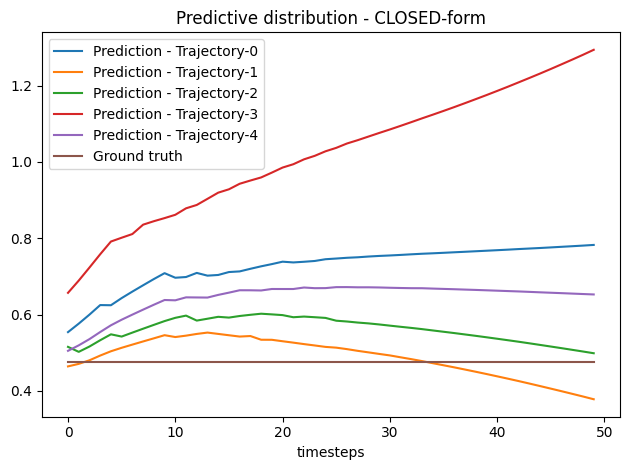

In [47]:
if not deterministic:
    x_trac_tensor = torch.concat(x_trajectories_closedform, dim=1).squeeze().cpu()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    for i in range(5):
        plt.plot(reversed_timesteps, x_trac_tensor[i].numpy(), label=f"Prediction - Trajectory-{i}")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - CLOSED-form")
    plt.tight_layout()

#### Sampled-form

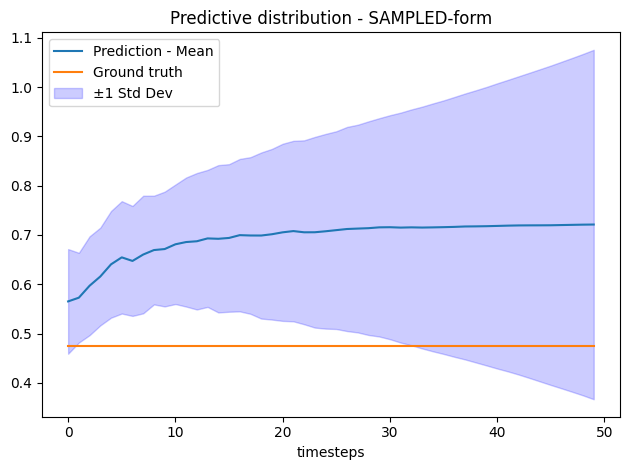

In [48]:
if not deterministic:
    means_over_time_sampled_form = np.array([distr_per_t_sampled_form[t][0].squeeze() for t in range(TIMESTEPS)]).squeeze()
    stds_over_time_sampled_form =  np.array([distr_per_t_sampled_form[t][1].squeeze() for t in range(TIMESTEPS)]).squeeze()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    plt.plot(reversed_timesteps, means_over_time_sampled_form, label="Prediction - Mean")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.fill_between(np.array(reversed_timesteps), means_over_time_sampled_form - stds_over_time_sampled_form, means_over_time_sampled_form + stds_over_time_sampled_form, color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - SAMPLED-form")
    plt.tight_layout()
    stds_over_time_sampled_form

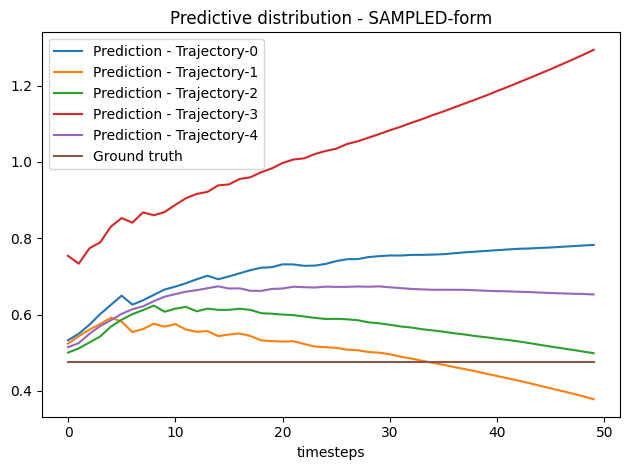

In [49]:
if not deterministic:
    x_trac_tensor = torch.concat(x_trajectories_sampledform, dim=1).squeeze().cpu()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    for i in range(5):
        plt.plot(reversed_timesteps, x_trac_tensor[i].numpy(), label=f"Prediction - Trajectory-{i}")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - SAMPLED-form")
    plt.tight_layout()

#### Deterministic

In [50]:
target

tensor([[0.4747]], device='cuda:0')

In [51]:
if deterministic:
    means_over_time_deterministic = np.array([distr_per_t_deterministic[t][0].squeeze() for t in range(TIMESTEPS)]).squeeze()
    stds_over_time_deterministic =  np.array([distr_per_t_deterministic[t][1].squeeze() for t in range(TIMESTEPS)]).squeeze()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    plt.plot(reversed_timesteps, means_over_time_deterministic, label="Prediction - Mean")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.fill_between(np.array(reversed_timesteps), means_over_time_deterministic - stds_over_time_deterministic, means_over_time_deterministic + stds_over_time_deterministic, color='blue', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - DETERMINISTIC")
    plt.tight_layout()

In [52]:
if deterministic:
    x_trac_tensor = torch.concat(x_trajectories_deterministic, dim=1).squeeze().cpu()

    reversed_timesteps = list(reversed(range(TIMESTEPS)))

    plt.figure()
    for i in range(5):
        plt.plot(reversed_timesteps, x_trac_tensor[i].numpy(), label=f"Prediction - Trajectory-{i}")
    plt.plot(reversed_timesteps, [target.item() for _ in reversed_timesteps], label="Ground truth")
    plt.xlabel("timesteps")
    plt.legend()
    plt.title(f"Predictive distribution - DETERMINISTIC")
    plt.tight_layout()

### Test only last timestep sampling

In [53]:
target, conditioning

(tensor([[0.4747]], device='cuda:0'),
 tensor([[-0.6786, -0.7734,  1.3703, -0.4983]], device='cuda:0'))

In [54]:
pred.shape

torch.Size([1, 1])

In [55]:
if not deterministic:
    with torch.no_grad():
        x = pred.clone()

        x_trajectories = [
            x
        ]

        n = x.shape[0]

        for i in reversed(range(2, TIMESTEPS)):
            t = torch.tensor([i]).long().to(device)
            curr_t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)

            predicted_noise = sample_noise(model, x_sampledform, curr_t_repeated, cond_repeated, pred_repeated)
            x_sampledform = sample_x_t_inference(x_sampledform, curr_t_repeated, predicted_noise, pred_repeated, i)

            distr_per_t_sampled_form.append(
                (x_sampledform.mean(axis=0).cpu(), x_sampledform.std(axis=0).cpu())
            )
            x_trajectories_sampledform.append(
                x_sampledform
            )

## Plot $X_0$ distribution

### Deterministic

In [56]:
#Deterministic
weights_directory = "results_power_CARD_sampling_and_epochs_likeCARD/20250818_095954_power"
weights_filename = "Datetime_20250818_095956_Loss_power-plant0_MLP_diffusion_deterministic_T50_DDIM1"
filename_to_validate_deterministic = f'{weights_directory}/{weights_filename}.pt'


training_parameters_deterministic = {
    'report_every': 50, 
    'seed': 1234, 
    'model': 'MLP', 
    'uncertainty_quantification': 'diffusion', 
    'backbone': 'CARD', 
    'batch_size': 64, 
    'eval_batch_size': 16384, 
    'n_epochs': 5000, 
    'early_stopping': 1000, 
    'init': 'default', 
    'learning_rate': 0.001, 
    'lr_schedule': 'no', 
    'optimizer': 'adam', 
    'gradient_clipping': 1, 
    'data_loader_pin_memory': False, 
    'data_loader_num_workers': 0, 
    'distributed_training': False, 
    'alpha': 0.05, 
    'n_samples_uq': 100, 
    'weight_decay': 0.0, 
    'dropout': 0.1, 
    'hidden_dim': 64, 
    'n_layers': 2, 
    'n_timesteps': T, 
    'distributional_method': "deterministic", #'deterministic', 'mixednormal', #closed_form_mixednormal', 
    'n_components': 3,
    'concat_condition_diffusion': True, 
    'evaluate': True, 
    'x_T_sampling_method': 'CARD', 
    'conditional_free_guidance_training': False, 
    'use_yarin_gal_loss': False, 
    'ddim_sigma': 1.0, 
    'noise_schedule': 'linear', 
    'regressor': 'orig_CARD_pretrain', 
    'metrics_plots': True, 
    'filename_to_validate': filename_to_validate
}

model_deterministic = train_utils.setup_model(
    data_parameters=data_parameters,
    training_parameters=training_parameters_deterministic,
    device=device,
    target_dim=image_dim,
    input_dim=label_dim,
)

train_utils.resume(model_deterministic, filename_to_validate_deterministic)


### Normal

In [57]:
# normal
weights_directory = "results_power_CARD_sampling_and_epochs_likeCARD/20250818_095954_power"
weights_filename = f"Datetime_20250818_105631_Loss_power-plant0_MLP_diffusion_normal_T50_DDIM1"
filename_to_validate_normal = f'{weights_directory}/{weights_filename}.pt'

training_parameters_normal = {
    'report_every': 50, 
    'seed': 1234, 
    'model': 'MLP', 
    'uncertainty_quantification': 'diffusion', 
    'backbone': 'CARD', 
    'batch_size': 64, 
    'eval_batch_size': 16384, 
    'n_epochs': 5000, 
    'early_stopping': 1000, 
    'init': 'default', 
    'learning_rate': 0.001, 
    'lr_schedule': 'no', 
    'optimizer': 'adam', 
    'gradient_clipping': 1, 
    'data_loader_pin_memory': False, 
    'data_loader_num_workers': 0, 
    'distributed_training': False, 
    'alpha': 0.05, 
    'n_samples_uq': 100, 
    'weight_decay': 0.0, 
    'dropout': 0.1, 
    'hidden_dim': 64, 
    'n_layers': 2, 
    'n_timesteps': T, 
    'distributional_method': "normal", #'deterministic', 'mixednormal', #closed_form_mixednormal', 
    'n_components': 3,
    'concat_condition_diffusion': True, 
    'evaluate': True, 
    'x_T_sampling_method': 'CARD', 
    'conditional_free_guidance_training': False, 
    'use_yarin_gal_loss': False, 
    'ddim_sigma': 1.0, 
    'noise_schedule': 'linear', 
    'regressor': 'orig_CARD_pretrain', 
    'metrics_plots': True, 
    'filename_to_validate': filename_to_validate
}

model_normal = train_utils.setup_model(
    data_parameters=data_parameters,
    training_parameters=training_parameters_normal,
    device=device,
    target_dim=image_dim,
    input_dim=label_dim,
)

train_utils.resume(model_normal, filename_to_validate_normal)

## Mixednormal

In [58]:
if not deterministic:
    with torch.no_grad():
        x_t = x_repeated + torch.randn_like(x_repeated).to(x.device)

        for i in reversed(range(TIMESTEPS-25, TIMESTEPS)):
            t = torch.tensor([i]).long().to(device)
            curr_t_repeated = t.repeat_interleave(N_SAMPLES, dim=0)

            predicted_mixture = model(x_t, curr_t_repeated, cond_repeated, pred_repeated)
            mu = predicted_mixture[..., 0]
            sigma = predicted_mixture[..., 1]
            weights = predicted_mixture[..., 2]
            sampled_weights = torch.distributions.Categorical(weights).sample()
            sampled_mu = torch.gather(mu, dim=-1, index=sampled_weights.unsqueeze(-1))
            sampled_sigma = torch.gather(
                sigma, dim=-1, index=sampled_weights.unsqueeze(-1)
            )
            predicted_noise = sampled_mu + sampled_sigma * torch.randn_like(
                sampled_mu, device=device
            )
            predicted_noise = predicted_noise.squeeze(-1)
            x_t_old = x_t
            x_t = sample_x_t_inference(x_t, curr_t_repeated, predicted_noise, pred_repeated, i)


In [59]:
predicted_mixture.squeeze()

tensor([[[-0.6107,  0.0175,  0.0631],
         [-0.4071,  0.0356,  0.2662],
         [-0.4375,  0.0696,  0.6706]],

        [[-0.6969,  0.0171,  0.0612],
         [-0.5074,  0.0349,  0.2665],
         [-0.5259,  0.0706,  0.6723]],

        [[-0.3449,  0.0200,  0.0620],
         [-0.0999,  0.0390,  0.2706],
         [-0.1700,  0.0681,  0.6674]],

        [[-0.5860,  0.0177,  0.0635],
         [-0.3783,  0.0358,  0.2663],
         [-0.4124,  0.0693,  0.6702]],

        [[ 0.4997,  0.0304,  0.0392],
         [ 0.7292,  0.0508,  0.2249],
         [ 0.6596,  0.0655,  0.7359]]], device='cuda:0')

In [60]:
deterministic_params = model_deterministic(x_t_old, curr_t_repeated, cond_repeated, pred_repeated).detach()
deterministic_params

tensor([[[-0.4350]],

        [[-0.5193]],

        [[-0.1668]],

        [[-0.4108]],

        [[ 0.6661]]], device='cuda:0')

In [61]:
normal_params = model_normal(x_t_old, curr_t_repeated, cond_repeated, pred_repeated).detach()
normal_params

tensor([[[[-0.4435,  0.0393]]],


        [[[-0.5310,  0.0395]]],


        [[[-0.1745,  0.0393]]],


        [[[-0.4184,  0.0393]]],


        [[[ 0.6835,  0.0427]]]], device='cuda:0')

In [62]:
epsilons = 1/( torch.sqrt(1-ALPHA_HAT[t])) * (x_t_old - torch.sqrt(ALPHA_HAT[t]) * target)
epsilons

tensor([[[-0.5206]],

        [[-0.7591]],

        [[ 0.2054]],

        [[-0.4526]],

        [[ 2.4718]]], device='cuda:0')

In [63]:
target

tensor([[0.4747]], device='cuda:0')

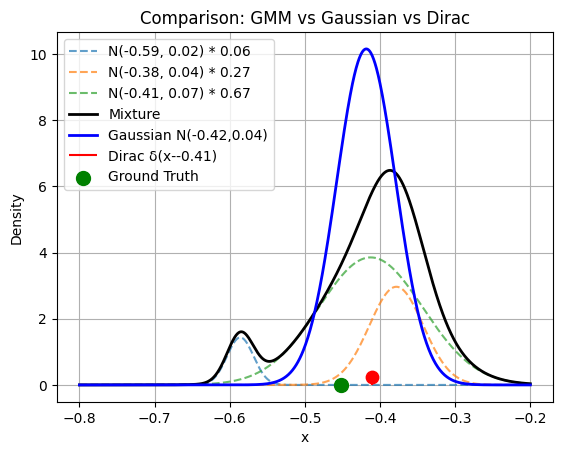

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_gmm_vs_gaussian_dirac(params, 
                               gaussian_params=(0, 1), 
                               dirac_location=0, 
                               ground_truth=None, 
                               x_range=(-0.8, -0.2), 
                               num_points=1000):
    """
    Plot a 1D Gaussian Mixture Model along with a Gaussian distribution, 
    a Dirac distribution (spike marker), and a ground truth marker.

    Args:
        params (ndarray): N x 3 matrix where each row is [mu, sigma, weight].
        gaussian_params (tuple): (mu, sigma) for the comparison Gaussian.
        dirac_location (float): Location of the Dirac delta function.
        ground_truth (float): Value for the ground truth marker (optional).
        x_range (tuple): Range of x values for plotting.
        num_points (int): Number of points in the x-axis grid.
    """
    params = np.array(params)
    mus = params[:, 0]
    sigmas = params[:, 1]
    weights = params[:, 2]

    # Normalize weights (in case they don't sum to 1)
    weights = weights / np.sum(weights)

    # X values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Mixture distribution
    mixture = np.zeros_like(x)
    for mu, sigma, w in zip(mus, sigmas, weights):
        component = w * norm.pdf(x, mu, sigma)
        mixture += component
        plt.plot(x, component, '--', alpha=0.7, label=f'N({mu:.2f}, {sigma:.2f}) * {w:.2f}')

    # Plot mixture
    plt.plot(x, mixture, 'k', linewidth=2, label="Mixture")

    # Comparison Gaussian
    mu_g, sigma_g = gaussian_params
    gaussian_pdf = norm.pdf(x, mu_g, sigma_g)
    plt.plot(x, gaussian_pdf, 'b-', linewidth=2, label=f'Gaussian N({mu_g:.2f},{sigma_g:.2f})')

    # Dirac delta (as spike)
    plt.vlines(dirac_location, 0, 0.25, color='r', linestyles='-', label=f'Dirac δ(x-{dirac_location:.2f})')
    plt.scatter([dirac_location], [0.25], c='r', s=80, marker='o', zorder=5)

    # Ground truth point
    if ground_truth is not None:
        plt.scatter([ground_truth], [0], c='g', s=100, marker='o', zorder=5, label="Ground Truth")

    plt.title("Comparison: GMM vs Gaussian vs Dirac")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:
params = [
    [0, 1, 0.3],   
    [3, 0.5, 0.4], 
    [-2, 0.8, 0.3] 
]

PLOT_IDX = 3

plot_gmm_vs_gaussian_dirac(
    predicted_mixture[PLOT_IDX].cpu().squeeze(), 
    gaussian_params=normal_params[PLOT_IDX].cpu().squeeze(), 
    dirac_location=deterministic_params[PLOT_IDX].cpu().squeeze(), 
    ground_truth=epsilons[PLOT_IDX].cpu(),
)

/home/groups/ai/kneissl/tmp/ipykernel_752676/708470480.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 4)


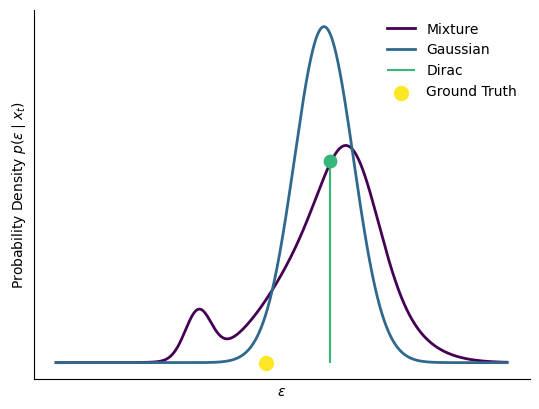

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.cm as cm

def plot_gmm_vs_gaussian_dirac_scientific(params, 
                               gaussian_params=(0, 1), 
                               dirac_location=0, 
                               ground_truth=None, 
                               x_range=(-10, 10), 
                               num_points=1000):
    """
    Plot a 1D Gaussian Mixture Model along with a Gaussian distribution, 
    a Dirac distribution (spike marker), and a ground truth marker.
    Uses a consistent colormap for visual harmony.
    """
    params = np.array(params)
    mus = params[:, 0]
    sigmas = params[:, 1]
    weights = params[:, 2]

    # Normalize weights (in case they don't sum to 1)
    weights = weights / np.sum(weights)

    # X values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Mixture distribution
    mixture = np.zeros_like(x)
    for mu, sigma, w in zip(mus, sigmas, weights):
        mixture += w * norm.pdf(x, mu, sigma)

    # --- Colors from viridis colormap ---
    cmap = cm.get_cmap("viridis", 4)
    c_mixture = cmap(0)      # darkest
    c_gaussian = cmap(1)     # medium-dark
    c_dirac = cmap(2)        # medium-bright
    c_truth = cmap(3)        # brightest

    # Plot mixture (distributional approach)
    plt.plot(x, mixture, color=c_mixture, linewidth=2, label="Mixture")

    # Comparison Gaussian
    mu_g, sigma_g = gaussian_params
    gaussian_pdf = norm.pdf(x, mu_g, sigma_g)
    plt.plot(x, gaussian_pdf, color=c_gaussian, linewidth=2, label="Gaussian")

    # Dirac delta (as spike)
    spike_height = max(mixture.max(), gaussian_pdf.max()) * 0.6
    plt.vlines(dirac_location, 0, spike_height, color=c_dirac, linestyles='-', label="Dirac")
    plt.scatter([dirac_location], [spike_height], c=[c_dirac], s=80, marker='o', zorder=5)

    # Ground truth point
    if ground_truth is not None:
        plt.scatter([ground_truth], [0], c=[c_truth], s=100, marker='o', zorder=5, label="Ground Truth")

    # Formatting for publication
    #plt.title("Qualitative Comparison of Distributional vs. Point Estimates")
    plt.xticks([])  
    plt.yticks([])  
    ax = plt.gca()  
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)  


    plt.xlabel(r"$\epsilon$")
    plt.ylabel(r"Probability Density $p(\epsilon \mid x_{t})$")
    plt.legend(frameon=False)
    plt.grid(False)
    plt.show()


PLOT_IDX = 0

plot_gmm_vs_gaussian_dirac_scientific(
    predicted_mixture[PLOT_IDX].cpu().squeeze(), 
    gaussian_params=normal_params[PLOT_IDX].cpu().squeeze(), 
    dirac_location=deterministic_params[PLOT_IDX].cpu().squeeze(), 
    ground_truth=epsilons[PLOT_IDX].cpu(),
    x_range=(-0.8, -0.2), 
)

/home/groups/ai/kneissl/tmp/ipykernel_752676/3734847593.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 4)


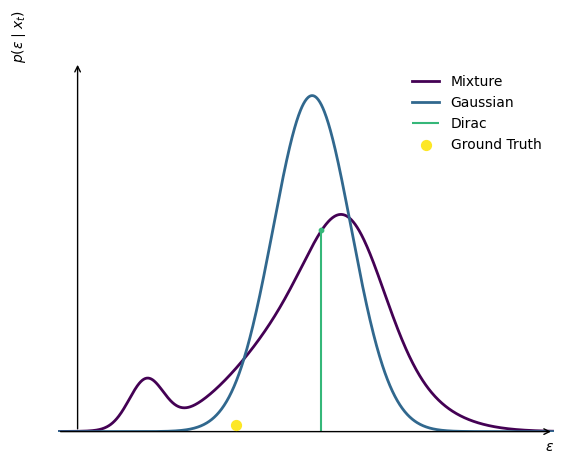

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.cm as cm

def plot_gmm_vs_gaussian_dirac(params, 
                               gaussian_params=(0, 1), 
                               dirac_location=0, 
                               ground_truth=None, 
                               x_range=(-10, 10), 
                               num_points=1000):
    """
    Scientific plot:
    - Custom axes with arrows
    - No box spines
    - LaTeX labels for epsilon
    """
    params = np.array(params)
    mus = params[:, 0]
    sigmas = params[:, 1]
    weights = params[:, 2]

    # Normalize weights
    weights = weights / np.sum(weights)

    # X values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Mixture distribution
    mixture = np.zeros_like(x)
    for mu, sigma, w in zip(mus, sigmas, weights):
        mixture += w * norm.pdf(x, mu, sigma)

    # --- Colors from viridis colormap ---
    cmap = cm.get_cmap("viridis", 4)
    c_mixture = cmap(0)      # darkest
    c_gaussian = cmap(1)     # medium-dark
    c_dirac = cmap(2)        # medium-bright
    c_truth = cmap(3)        # brightest

    # Plot mixture (distributional approach)
    plt.plot(x, mixture, color=c_mixture, linewidth=2, label="Mixture")

    # Comparison Gaussian
    mu_g, sigma_g = gaussian_params
    gaussian_pdf = norm.pdf(x, mu_g, sigma_g)
    plt.plot(x, gaussian_pdf, color=c_gaussian, linewidth=2, label="Gaussian")

    # Dirac delta (as spike)
    spike_height = max(mixture.max(), gaussian_pdf.max()) * 0.6
    plt.vlines(dirac_location, 0, spike_height, color=c_dirac, linestyles='-', label="Dirac")
    plt.scatter([dirac_location], [spike_height], c=[c_dirac], s=10, marker='o', zorder=5)

    ax = plt.gca()

    # Ground truth point
    if ground_truth is not None:
        plt.scatter([ground_truth], [0.02 * ax.get_ylim()[1]], c=[c_truth], s=50, marker='o', zorder=5, label="Ground Truth")

    # Remove ticks and numbers
    plt.xticks([])
    plt.yticks([])
    
    # Hide default spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set limits
    y_lim = max(mixture.max(), gaussian_pdf.max()) * 1.1
    plt.xlim(x_range)
    plt.ylim(0, y_lim)

    # Position for custom y-axis
    y_axis_x = -0.68  

    # Draw custom axes with arrows
    ax.annotate("", xy=(x_range[1], 0), xytext=(x_range[0], 0),
                arrowprops=dict(arrowstyle="->", color="black"))
    ax.annotate("", xy=(y_axis_x, ax.get_ylim()[1]), xytext=(y_axis_x, 0),
                arrowprops=dict(arrowstyle="->", color="black"))

    # Axis labels in LaTeX
    ax.text(x_range[1], -0.02*ax.get_ylim()[1], r"$\epsilon$", ha="right", va="top")
    ax.text(y_axis_x-0.05, ax.get_ylim()[1], r"$p(\epsilon \mid x_{t})$", 
            ha="right", va="bottom", rotation=90)
    # Legend
    plt.legend(frameon=False)

    plt.savefig("transition_distribution.svg", format="svg")
    plt.savefig("transition_distribution.pdf", format="pdf")
    plt.show()

    


# Example usage
params = [
    [0, 1, 0.3],   
    [3, 0.5, 0.4], 
    [-2, 0.8, 0.3] 
]


plot_gmm_vs_gaussian_dirac(
    predicted_mixture[PLOT_IDX].cpu().squeeze(), 
    gaussian_params=normal_params[PLOT_IDX].cpu().squeeze(), 
    dirac_location=deterministic_params[PLOT_IDX].cpu().squeeze(), 
    ground_truth=epsilons[PLOT_IDX].cpu(),
    x_range=(-0.7, -0.2), 
)

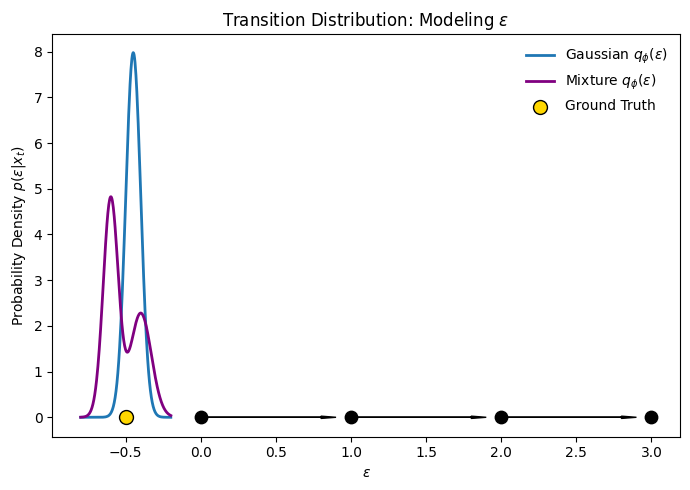

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, ax = plt.subplots(figsize=(7,5))

# Time steps for diffusion process
t = np.array([0, 1, 2, 3])
x = np.zeros_like(t)

# Plot diffusion process as circles
ax.scatter(t, x, c='black', s=80, zorder=3)

# Draw arrows between steps
for i in range(len(t)-1):
    ax.arrow(t[i], 0, 0.8, 0, head_width=0.05, head_length=0.1, fc='k', ec='k', zorder=2)

# Add epsilon distribution illustrations
x_vals = np.linspace(-0.8, -0.2, 200)

# Example Gaussian distribution
mu, sigma = -0.45, 0.05
gaussian = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x_vals-mu)**2/(2*sigma**2))
ax.plot(x_vals, gaussian, color="tab:blue", lw=2, label="Gaussian $q_\phi(\epsilon)$")

# Example Mixture of Gaussians
gaussian1 = 0.6 * 1/(0.05*np.sqrt(2*np.pi)) * np.exp(-(x_vals+0.6)**2/(2*0.05**2))
gaussian2 = 0.4 * 1/(0.07*np.sqrt(2*np.pi)) * np.exp(-(x_vals+0.4)**2/(2*0.07**2))
mixture = gaussian1 + gaussian2
ax.plot(x_vals, mixture, color="purple", lw=2, label="Mixture $q_\phi(\epsilon)$")

# Ground truth marker
ax.scatter([-0.5], [0], s=100, color="gold", edgecolor="black", zorder=4, label="Ground Truth")

# Axis styling
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"Probability Density $p(\epsilon|x_t)$")
ax.set_title("Transition Distribution: Modeling $\epsilon$")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()
